# 多决策树 - 随机森林 - 随机决策
对决策树的一个常见批评是，一旦在回答问题后对训练集进行划分，就不可能重新考虑这个决策。例如，如果我们将男性和女性分开，那么每个后续问题都只涉及男性或女性，而且该方法不能考虑其他类型的问题（例如，年龄不到一岁，不论性别如何）。**随机森林**尝试在每个步骤中引入一定程度的**随机化**，创建备选树并将它们组合来获得最终预测。考虑几个回答相同问题的分类器的这些类型的算法，被称为**集成方法**.   
随机森林建议基于训练实例的子集（**带放回随机选择**）来构建决策树，但是在特征集的每个集合中使用少量随机的特征。这种树生长过程重复几次，产生一组分类器。在预测时，给定一个实例的每个成型的树都会像决策树一样预测其目标类。大多数树所投票的类（即树中预测最多的类）是集成分类器所建议的类。  
随机森林只是许多树，建立在数据的不同随机子集（带放回抽样）上，并对于每个分裂，使用特征的不同随机子集（无放回抽样）。 这使得树彼此不同，并使它们过拟合不同的方面。 然后，他们的预测被平均，产生更平稳的估计，更少过拟合。

声呐信号分析 [来源](https://github.com/apachecn/AiLearning/blob/master/docs/ml/7.%E9%9B%86%E6%88%90%E6%96%B9%E6%B3%95-%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97%E5%92%8CAdaBoost.md#%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97)
---

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True, precision=4, threshold=16)

In [30]:
def load_data(file_path):
    with open(file_path) as f:
        data = []
        for line in f.readlines():
            if not line:
                continue
            line_data = []
            for str_ in line.split(','):
                str_ = str_.strip()
                if str_.isdigit():
                    line_data.append(float(str_))
                else:
                    line_data.append(str_)
            data.append(line_data)
        return data

In [31]:
data = np.array(load_data('/mnt/data1/workspace/AI/data/机器学习/7.RandomForest/sonar-all-data.txt'))
data

array([['0.02', '0.0371', '0.0428', ..., '0.009', '0.0032', 'R'],
       ['0.0453', '0.0523', '0.0843', ..., '0.0052', '0.0044', 'R'],
       ['0.0262', '0.0582', '0.1099', ..., '0.0095', '0.0078', 'R'],
       ...,
       ['0.0522', '0.0437', '0.018', ..., '0.0077', '0.0031', 'M'],
       ['0.0303', '0.0353', '0.049', ..., '0.0036', '0.0048', 'M'],
       ['0.026', '0.0363', '0.0136', ..., '0.0061', '0.0115', 'M']],
      dtype='<U6')

In [74]:
import re
pattern = re.compile(r"\d+(\.\d+)?")

In [4]:
data = np.array(load_data('/mnt/data1/workspace/AI/data/机器学习/7.RandomForest/sonar-all-data.txt'))
X, y = data[:, :-1].astype(float), data[:, -1]
labels, indices_u = np.unique(y, return_inverse=True)
y_ = np.where(indices_u == 0, -1, indices_u)
y_

array([ 1,  1,  1, ..., -1, -1, -1])

In [20]:
labels

array(['M', 'R'], dtype='<U6')

In [21]:
X.shape

(208, 60)

In [7]:
# 定义节点类 CART 二叉树
class Node:
    def __init__(self, root=True, label=None, feature=None, value=None):
        self.root = root  # 当前节点是叶节点了
        self.label = label  # 节点的分类
        # self.feature_name = feature_name  # 节点划分子集使用的特征名
        self.feature = feature   # 当前节点 划分子集使用的特征编号
        self.tree = {}  # 子节点
        self.value = value  # 分割值

    def __repr__(self): 
        result = {
            'label': self.label,
            'feature': self.feature,
            'value': self.value,
            'tree': self.tree
        }
        if not self.label:
            result.pop('label')
        if not self.tree:
            result.pop('tree')
        if not self.feature:
            result.pop('feature')
        if self.value is None:
            result.pop('value')   
        return '{}'.format(result)

    def add_node(self, val, node):
        self.tree[val] = node

    def predict(self, X):
        # X 单个特征样本
        if self.root is True:
            return self.label
        if X[self.feature] >= self.value :
            return self.tree['left'].predict(X)
        else:
            return self.tree['right'].predict(X)

In [8]:
class CART:
    def __init__(self, epsilon=0.1, sample_least=5):
        self.epsilon = epsilon  # 基尼指数阈值
        self.sample_least = sample_least
        self._tree = {}
    
    @staticmethod
    def gini_(y1, y2):
        # 获取当前样本集 的gini指数
        ginis = []
        
        for y in (y1, y2):
            # Gini(D) = 1- \sum (|C_k|/|D|)^2
            labels, counts = np.unique(y, return_counts=True)
            gini = 1- np.sum((counts / np.sum(counts)) ** 2)
            ginis.append(gini)
        # Gini(D, A) = |D1| / |D| * gini(D1) + |D2| / |D| * gini(D2)
        A = np.array([len(y1), len(y2)])
        # print(ginis, A)
        gini_A = (ginis * (A / A.sum())).sum()
        return gini_A
    
    @staticmethod
    def data_split(X, feature, value):
        # 根据特征和value 分割数据 返回序号
        data_set = X[:, feature]
        left , right = [], []
        for i in range(len(data_set)):
            if data_set[i] >= value:
                left.append(i)
            else:
                right.append(i)
        return left, right
    
    def choose_best_value(self, data, y, feature):
        # 返回最佳分割点和相应的gini指数
        # 选定特征A, A的不同划分取值a 下的gini指数
        value_split_list = np.sort(data[:, feature])
        value_split = (value_split_list[1:] + value_split_list[:-1]) / 2
        gini_one_feature = []
        
        for value in value_split:
            # 每个划分点计算 基尼指数
            left, right = self.data_split(data, feature, value)
            gini = self.gini_(y[left], y[right])
            gini_one_feature.append(gini)
        # 得到最小的gini
        min_index = np.argmin(gini_one_feature)
        return value_split[min_index], gini_one_feature[min_index] 

    def choose_best_feature(self, X, y, features):
        # 寻找最好的 分割特征和分割值
        temp = np.zeros((len(features), 3))
        for i, feature in enumerate(features):
            value, gini = self.choose_best_value(X, y, feature)
            temp[i] = [gini, feature, value]
        best = np.argmin(temp[:, 0])
        return temp[best]
    
    def build_tree(self, X, y, features):
        X = X.copy()
        y = y.copy()
        u, counts = np.unique(y, return_counts=True)
        # 1, 样本个数小于预订阈值, 多数表决
        if len(X) < self.sample_least:
            return Node(root=True, label=u[counts.argmax()])
        
        # 2, 若A为空，没有特征继续进行划分了, 则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(root=True, label=u[counts.argmax()])
        
        # 3. 计算 最佳的特征 分割点 gini
        gini, feature, value = self.choose_best_feature(X, y, features)
        # 3个一同存储的, 会变成float类型
        feature = int(feature)
        
        # 4 gini指数小于某一值
        if gini < self.epsilon:
            return Node(root=True, label=u[counts.argmax()], value=value)
        
        # 5 构建结点
        node_tree = Node(root=False, feature=feature, value=value)
        features_copy = features.copy()  # 纯数字list的copy
        features_copy.remove(feature)
        # 左>=  右<
        # 6 递归生成树
        left, right = self.data_split(X, feature, value)
        # print(len(left), len(right), X.shape, y.shape)
        left_tree = self.build_tree(X[left], y[left], features_copy)
        node_tree.add_node('left', left_tree)
        right_tree = self.build_tree(X[right], y[right], features_copy)
        node_tree.add_node('right', right_tree)
        
        return node_tree
        
    def fit(self, X, y, features):
        print('选择的特征', features)
        self._tree = self.build_tree(X, y, features)
        return self._tree
            
    def predict(self, X):
        ret = np.zeros(X.shape[0])
        for i, sample in enumerate(X):
            ret[i] = (self._tree.predict(sample))
        return ret
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y_pred == y) / len(y)

In [9]:
cart_tree = CART()
feature_all = list(range(X.shape[1]))
cart_tree.fit(X, indices_u, feature_all)

选择的特征 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


{'feature': 10, 'value': 0.19795000000000001, 'tree': {'left': {'feature': 15, 'value': 0.66655, 'tree': {'left': {'feature': 30, 'value': 0.39980000000000004, 'tree': {'left': {'label': 1, 'value': 0.011300000000000001}, 'right': {'feature': 14, 'value': 0.5222500000000001, 'tree': {'left': {'value': 0.34704999999999997}, 'right': {'label': 1}}}}}, 'right': {'feature': 33, 'value': 0.69215, 'tree': {'left': {'feature': 44, 'value': 0.252, 'tree': {'left': {'value': 0.01005}, 'right': {'label': 1, 'value': 0.009049999999999999}}}, 'right': {'value': 0.0039}}}}}, 'right': {'feature': 3, 'value': 0.051500000000000004, 'tree': {'left': {'feature': 44, 'value': 0.16155, 'tree': {'left': {'value': 0.01405}, 'right': {'label': 1, 'value': 0.05585}}}, 'right': {'value': 0.03925, 'tree': {'left': {}, 'right': {'label': 1, 'value': 0.9907}}}}}}}

In [10]:
cart_tree.score(X, indices_u)  # X 的正确率

0.9230769230769231

In [12]:
def bagging(n_sample, tree_num):
    # 样本数据随机化 为每棵树生成n_sample个样本
    indices = np.random.randint(0, n_sample, size=(tree_num, n_sample))
    oobs = []
    for sample in indices:
        # 为棵树添加oob
        oobs.append(np.setdiff1d(range(n_sample), sample))
    return indices, oobs

In [13]:
indices, oobs = bagging(100, 5)

In [22]:
oobs[1].shape, oobs[2].shape

((40,), (32,))

In [102]:
class CARTRandom(CART):
    def __init__(self, epsilon=0.1, sample_least=5, feature_num=10):
        super().__init__(epsilon, sample_least)
        self.feature_num = feature_num
    
    def build_tree(self, X, y, features):
        X = X.copy()
        y = y.copy()
        u, counts = np.unique(y, return_counts=True)
        # 1, 样本个数小于预订阈值, 多数表决
        if len(X) < self.sample_least:
            return Node(root=True, label=u[counts.argmax()])
        
        # 2, 若A为空，没有特征继续进行划分了, 则T为单节点树，将D中实例树最大的类Ck作为该节点的类标记，返回T
        if len(features) == 0:
            return Node(root=True, label=u[counts.argmax()])
        
        # 3. 计算 最佳的特征 分割点 gini
        # RandomForest从随机选择的特征中选最好的
        features_select = np.random.choice(features, self.feature_num, replace=False)
        gini, feature, value = self.choose_best_feature(X, y, features_select)
        # 3个一同存储的, 会变成float类型
        feature = int(feature)
        
        # 4 gini指数小于某一值
        if gini < self.epsilon:
            return Node(root=True, label=u[counts.argmax()], value=value)
        
        # 5 构建结点
        node_tree = Node(root=False, feature=feature, value=value)
        features_copy = features.copy()  # 纯数字list的copy
        features_copy.remove(feature)
        # 左>=  右<
        # 6 递归生成树
        left, right = self.data_split(X, feature, value)
        # print(len(left), len(right), X.shape, y.shape)
        left_tree = self.build_tree(X[left], y[left], features_copy)
        node_tree.add_node('left', left_tree)
        right_tree = self.build_tree(X[right], y[right], features_copy)
        node_tree.add_node('right', right_tree)
        
        return node_tree
        
    def fit(self, X, y, features):
        # print('选择的特征', features)
        self._tree = self.build_tree(X, y, features)
        return self._tree

In [105]:
class RamdomForest:
    def __init__(self, T=21, random_state=0, feature_nums=6):
        self.T = T  #  Bagging 方法生成T棵 DT
        np.random.seed(random_state)
        self.feature_nums = feature_nums  # 选定多少个特征构建决策树
        self.trees = []
        self.self_validation = 0.0
        
    @staticmethod
    def bagging(n_sample, tree_num):
        # 样本数据随机化 为每棵树生成n_sample个样本
        indices = np.random.randint(0, n_sample, size=(tree_num, n_sample))
        oobs = []
        for sample in indices:
            # 为棵树添加oob
            oobs.append(np.setdiff1d(range(n_sample), sample))
        return indices, oobs
    
    # @staticmethod
    # def random_feature(tree_num, n_feature, feature_nums):
    #     # 每棵树都从M个特征中选取m个
    #     feature_array = np.zeros((tree_num, feature_nums))
    #     for i in range(tree_num):
    #         feature_index = np.arange(n_feature)
    #         np.random.shuffle(feature_index)
    #         feature_selected = feature_index[:feature_nums]
    #         feature_array[i,:] = feature_selected
    #     return feature_array.astype(int)
        
    def fit(self, X, y):
        n_sample, n_feature = X.shape
        indices, oobs = self.bagging(n_sample, self.T)
        # features = self.random_feature(self.T, n_feature, self.feature_nums)
        features = list(range(X.shape[1]))
        X_samples, y_samples = X[indices, :], y[indices]
        
        
        for i in range(self.T):
            tree = CARTRandom(epsilon=0.1, sample_least=5, feature_num=self.feature_nums)
            tree.fit(X_samples[i, :], y_samples[i], features)  # 转成list 方便操作
            self.trees.append(tree)
        
        y_pred = []
        for i in range(n_sample):
            y_pred_i = []
            for j in range(self.T): 
                # 如果(X_n, y_n)是某棵树的oob, 则使用这棵树判断此样本
                if i in oobs[j]:  # [1, 2 ,5, ...]
                    y_pred_i.append(self.trees[j].predict(X[[i]]))
            # 取平均 计算当前样本预测值 
            y_i = np.mean(y_pred_i) # np.array(y_pred_i).ravel().mean()
            y_pred.append(1 if y_i >= 0 else -1)
        # 所有样本的平均表现
        self.self_validation = np.sum(y_pred == y) / n_sample
    
    
    def predict(self, X):
        y_pred = np.zeros((self.T, X.shape[0]))
        for i in range(self.T):
            y_pred[i] = self.trees[i].predict(X)
        y = np.where(np.average(y_pred, axis=0)>0, 1, -1)
        return y
        
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.sum(y==y_pred)/ len(y)

In [106]:
rf = RamdomForest(random_state=12345)
rf.fit(X, y_)

In [107]:
rf.self_validation

0.7740384615384616

In [108]:
rf.score(X, y_)  # 比单一决策树好

0.9807692307692307

**使用sklearn解决**

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score

# scikit-learn 的实现是取每个分类器预测概率的平均，
# 而不是让每个分类器对类别进行投票
rf = RandomForestClassifier(n_estimators=21, random_state=12345,                                n_jobs=-1, oob_score=True, max_depth=7)
rf.fit(X, y_)

RandomForestClassifier(max_depth=7, n_estimators=21, n_jobs=-1, oob_score=True,
                       random_state=12345)

In [114]:
rf.score(X, y_)

1.0

In [115]:
# 查看oob得分
rf.oob_score_

0.8269230769230769

## sk-learn 官方User Guide的例子 

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics
import matplotlib.pyplot as plt
import graphviz
from sklearn import datasets
import pandas as pd
import numpy as np
np.set_printoptions(precision=4, suppress=True, threshold=15)
pd.options.display.max_rows = 20

In [117]:
iris = datasets.load_iris()
X, y = iris.data, iris.target

[数据科学和人工智能技术笔记 十三、树和森林](https://github.com/apachecn/ds-ai-tech-notes/blob/master/13.md)

In [118]:
# 使用随机森林
clf = RandomForestClassifier(random_state=12345, n_jobs=-1)
clf.fit(X, y)

RandomForestClassifier(n_jobs=-1, random_state=12345)

**特征的重要性**

In [119]:
# 计算特征重要性  越接近于1 表示越重要
importances = clf.feature_importances_  # 所有重要性得分加起来为 100%
importances  

array([0.087 , 0.0213, 0.4622, 0.4294])

([<matplotlib.axis.XTick at 0x7f8dda3e7cd0>,
 [Text(0, 0, 'sepal length (cm)'),
  Text(0, 0, 'sepal width (cm)'),
  Text(0, 0, 'petal length (cm)'),
  Text(0, 0, 'petal width (cm)')])

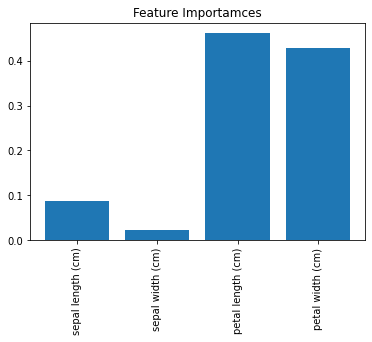

In [120]:
# 整个数据集上的特征重要性分布
plt.bar(range(X.shape[1]), importances)
plt.title('Feature Importamces')
plt.xticks(range(X.shape[1]), iris.feature_names, rotation=90)

**使用随机森林的特征选择**

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

In [123]:
clf = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10000, n_jobs=-1, random_state=0)

In [124]:
# 使用4个特征进行分类的 准确率
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9333333333333333

In [125]:
clf.score(X_test, y_test)

0.9333333333333333

In [126]:
SelectFromModel?

Init signature:
SelectFromModel(
    estimator,
    *,
    threshold=None,
    prefit=False,
    norm_order=1,
    max_features=None,
)
Docstring:     
Meta-transformer for selecting features based on importance weights.

.. versionadded:: 0.17

Parameters
----------
estimator : object
    The base estimator from which the transformer is built.
    This can be both a fitted (if ``prefit`` is set to True)
    or a non-fitted estimator. The estimator must have either a
    ``feature_importances_`` or ``coef_`` attribute after fitting.

threshold : string, float, optional default None
    The threshold value to use for feature selection. Features whose
    importance is greater or equal are kept while the others are
    discarded. If "median" (resp. "mean"), then the ``threshold`` value is
    the median (resp. the mean) of the feature importances. A scaling
    factor (e.g., "1.25*mean") may also be used. If None and if the
    estimator has a parameter penalty set to l1, either explicit

In [127]:
# 创建一个选择器对象，
# 该对象将使用随机森林分类器来标识重要性大于 0.15的特征
sfm = SelectFromModel(clf, threshold=0.15)
sfm.fit(X_train, y_train)
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)
X_important_train

array([[4.5, 1.6],
       [1.6, 0.2],
       [5.1, 1.9],
       ...,
       [4.1, 1. ],
       [6.7, 2.2],
       [1.4, 0.2]])

In [128]:
sfm.get_support(indices=True)  # 所选择的特征编号

array([2, 3])

In [129]:
sfm.get_support()

array([False, False,  True,  True])

In [130]:
important_names = np.array(iris.feature_names)[sfm.get_support()]
important_names  # 最重要的2个特征

array(['petal length (cm)', 'petal width (cm)'], dtype='<U17')

In [131]:
# 使用最重要的特征 训练随机森林
clf_important = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1)
clf_important.fit(X_important_train, y_train)
# 使用2个特征 的模型准确率
y_pred = clf_important.predict(X_important_test)
metrics.accuracy_score(y_test, y_pred)

0.9

**在随机森林中处理不平衡类别**

In [132]:
# 通过移除前 40 个观测，生成高度不平衡的类别
X = X[30:, ]
y = y[30:]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

其中类自动加权，与它们在数据中出现的频率成反比  
$$w_j = \frac {n}{kn_j}$$
$w_j$是$j$类的权重, $n$是总观测数, $n_j$是类$j$的观测数, $k$为类的总数

In [133]:
clf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=0)

In [134]:
y_pred = clf.predict(X_test)
metrics.accuracy_score(y_test, y_pred)

0.9375